# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pyvisa # control gpib, tcp/ip etc...
import nidaqmx # Control ni-usb-6002
import paramiko
from scp import SCPClient   
import os
from matplotlib.animation import FuncAnimation
from itertools import count
import cv2
import natsort
import scipy
import lmfit


# for APT control of thorlab stages
from pylablib.devices import Thorlabs

## point grey research camera NOW FLIR
from rotpy.system import SpinSystem
from rotpy.camera import CameraList

In [8]:
def takepic_pointgrey(fname):
    camera.begin_acquisition()
    image_cam=camera.get_next_image(timeout=5)
    image=image_cam.deep_copy_image(image_cam)
    image_cam.release()
    camera.end_acquisition()
    image.save_png(fname+'.png')

# Camera

In [955]:
system=SpinSystem()
cameras=CameraList.create_from_system(system, update_cams=1,update_interfaces=1)
camera=cameras.create_camera_by_index(0)
camera.init_cam()
# camera.camera_nodes.DeviceSerialNumber.get_node_value()
# serial number:'17103104'

In [979]:
camera.deinit_cam()

In [88]:
fname='test'
takepic_pointgrey(fname)

# Stage initilization

In [9]:
Thorlabs.list_kinesis_devices()

[('26005194', 'Stepper Controller'),
 ('55309874', 'Kinesis K10CR1 Rotary Stage'),
 ('55358414', 'Kinesis K10CR1 Rotary Stage'),
 ('55358394', 'Kinesis K10CR1 Rotary Stage'),
 ('26001408', 'Stepper Controller')]

In [10]:
################# APT control of stages
# Thorlabs.list_kinesis_devices()

stagex = Thorlabs.KinesisMotor("26005194")
stagey = Thorlabs.KinesisMotor("26001408")
# stagez = Thorlabs.KinesisPiezoMotor("97101351")

print(r'10000 step is about %.4f um'%(4.6))

10000 step is about 4.6000 um


In [947]:
# move TOP RIGHT with backlash
stagex.move_by(int(-1600))

In [949]:
# move DOWN LEFT WITHOUT backlash
stagex.move_by(int(1500))

In [945]:
# move DOWN RIGHT WITHOUT backlash
stagey.move_by(int(1600))

In [948]:
# move TOP LEFT WITH backlash
stagey.move_by(int(-1600))

In [ ]:
stagex.stop()

In [261]:
stagey.stop()

In [158]:
stagex.get_position()

2678365

In [159]:
stagey.get_position()

1349301

In [980]:
stagex.close()

In [981]:
stagey.close()

# Drift correction v240323

In [584]:
def find_feature_position(image, template):
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)  # Normalized correlation coefficient
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    return max_loc[0], max_loc[1]

# Function to find the brightest spot (laser)
def find_laser_position(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to isolate the bright spot
    thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)[1] 

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area (assumed to be the laser)
    max_area_contour = max(contours, key=cv2.contourArea) 

    # Calculate center of the contour
    M = cv2.moments(max_area_contour)
    center_x = int(M["m10"] / M["m00"]) 
    center_y = int(M["m01"] / M["m00"]) 

    return center_x, center_y

def correct_drift(drift_x,drift_y,calibration_matrix):
    move_x,move_y=np.dot(calibration_matrix,(-drift_x,-drift_y))
    stagex.move_by(move_x);time.sleep(1)
    stagey.move_by(move_y);time.sleep(1)
    
def calibrate_stage(image_ROI):
    stage_movements=[]
    pixel_shifts=[]
    
    steps=np.array([(5000,0),(0,5000),(-5000,-5000),(-3000,0),(0,-3000),(3000,3000)])
    for i in range(len(steps)):
        fname='image_temp'
        takepic_pointgrey(fname)
        image_initial = cv2.imread(fname+'.png')
      # Find feature in the initial image
        result = cv2.matchTemplate(image_initial, image_ROI, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        print(max_val,max_loc)
        initial_position = max_loc
        
        stagex.move_by(int(steps[i,0]));time.sleep(1)
        print(f'x moved by {steps[i,0]}')
        stagey.move_by(int(steps[i,1]));time.sleep(1)
        print(f'y moved by {steps[i,1]}')

        takepic_pointgrey(fname)
        image_moved = cv2.imread(fname+'.png')
        result = cv2.matchTemplate(image_moved, image_ROI, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        print(max_val,max_loc)
        pixel_shift = (max_loc[0] - initial_position[0], max_loc[1] - initial_position[1]) 
        stage_movements.append([steps[i,0],steps[i,1]])
        pixel_shifts.append([pixel_shift[0],pixel_shift[1]])
    
    print(stage_movements)
    print(pixel_shifts)
    calibration_matrix = np.linalg.lstsq(pixel_shifts,stage_movements,rcond=None)[0].T
    return calibration_matrix


## Set ROI

In [707]:
fname='image_current'
takepic_pointgrey(fname)
image_current = cv2.imread(fname+'.png')

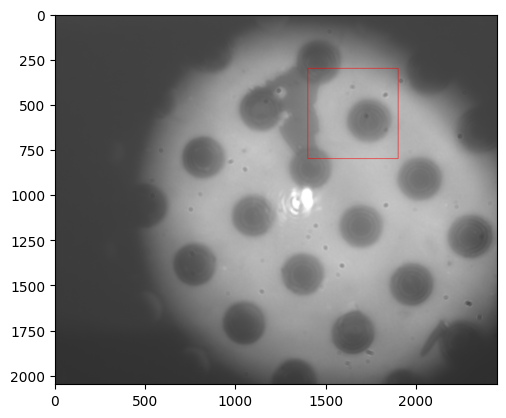

In [708]:
x_start = 1400 
y_start = 300  
width = 500   
height = 500   
image_ROI = image_current[y_start:y_start+height, x_start:x_start+width]

feature_position = find_feature_position(image_current, image_ROI)

x, y = feature_position
cv2.rectangle(image_current, (x, y), (x + image_ROI.shape[1], y + image_ROI.shape[0]), 255, 2)
plt.imshow(image_current)

## Stage calibration

In [709]:
calibration_matrix=calibrate_stage(image_ROI)

0.8589708805084229 (1400, 300)
x moved by 5000
y moved by 0
0.8141002058982849 (1446, 254)
0.8140470385551453 (1446, 254)
x moved by 0
y moved by 5000
0.7982891798019409 (1406, 218)
0.7976368069648743 (1405, 218)
x moved by -5000
y moved by -5000
0.856934130191803 (1397, 298)
0.8565999865531921 (1396, 298)
x moved by -3000
y moved by 0
0.843683660030365 (1369, 318)
0.843867838382721 (1370, 318)
x moved by 0
y moved by -3000
0.8388033509254456 (1394, 342)
0.83884596824646 (1394, 340)
x moved by 3000
y moved by 3000
0.8573037385940552 (1397, 300)
[[5000, 0], [0, 5000], [-5000, -5000], [-3000, 0], [0, -3000], [3000, 3000]]
[[46, -46], [-40, -36], [-8, 80], [-27, 20], [24, 24], [3, -40]]


## Set initial state

Initial ROI position is at (1397, 298)


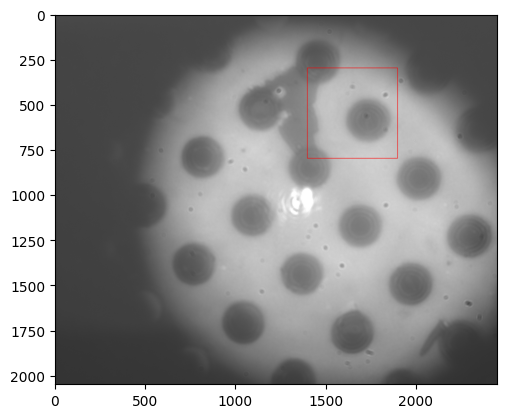

In [710]:
fname='image_initial'
takepic_pointgrey(fname)
image = cv2.imread(fname+'.png')
initial_ROI_position=find_feature_position(image,image_ROI)
print('Initial ROI position is at',initial_ROI_position)

x, y = initial_ROI_position
cv2.rectangle(image, (x, y), (x + image_ROI.shape[1], y + image_ROI.shape[0]), 255, 2)
plt.imshow(image)

## Drifted state

In [579]:
# move TOP RIGHT with backlash
stagey.move_by(int(-8600));time.sleep(1)

Drifted ROI position is at (1870, 770)


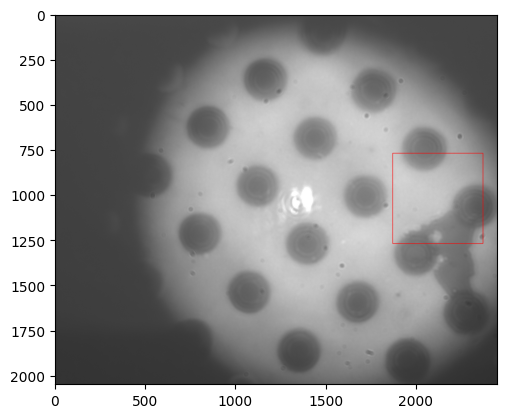

In [580]:
fname='image_drifted'
takepic_pointgrey(fname)
image = cv2.imread(fname+'.png')
drifted_ROI_position=find_feature_position(image,image_ROI)
print('Drifted ROI position is at',drifted_ROI_position)

x, y = drifted_ROI_position
cv2.rectangle(image, (x, y), (x + image_ROI.shape[1], y + image_ROI.shape[0]), 255, 2)
plt.imshow(image)

## Correct drift

In [581]:
drift_x,drift_y=drifted_ROI_position[0]-initial_ROI_position[0],\
                  drifted_ROI_position[1]-initial_ROI_position[1]
print(drift_x,drift_y)

70 70


In [582]:
correct_drift(drift_x,drift_y,calibration_matrix)

Corrected ROI position is at (1799, 698)


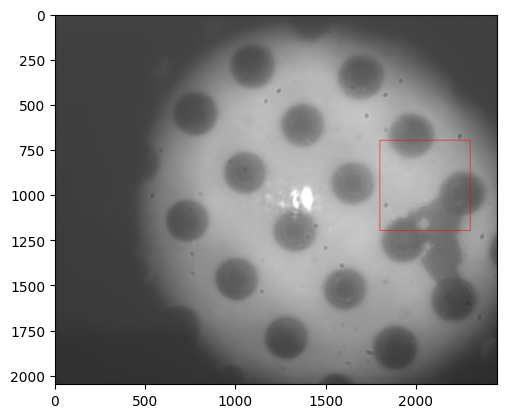

In [583]:
fname='image_corrected'
takepic_pointgrey(fname)
image = cv2.imread(fname+'.png')
corrected_ROI_position=find_feature_position(image,image_ROI)
print('Corrected ROI position is at',corrected_ROI_position)

x, y = corrected_ROI_position
# Draw a rectangle around the feature for visualization
cv2.rectangle(image, (x, y), (x + image_ROI.shape[1], y + image_ROI.shape[0]), 255, 2)
plt.imshow(image)

## Laser position Finder

Laser position is at (1394, 1019)


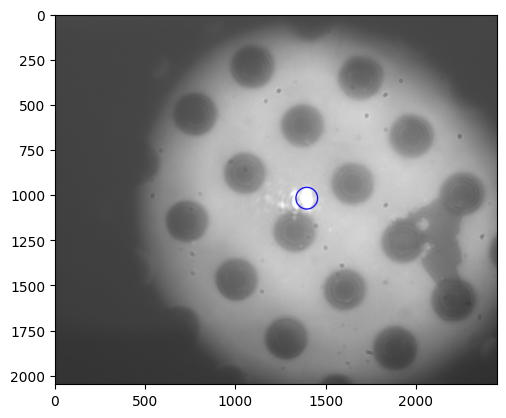

In [572]:
fname='image_current'
takepic_pointgrey(fname)
image = cv2.imread(fname+'.png')
laser_position=find_laser_position(image)
print('Laser position is at',laser_position)

x, y = laser_position
# Draw a rectangle around the feature for visualization

cv2.circle(image, laser_position, 60, (0, 0, 255), 5) 
plt.imshow(image)

# Continuous correction

In [963]:
fname='240324a1_YIGDISK'
fname='240324_test'
os.mkdir('D:/Jupyter_notebooks/Kyongmo/2403/Pictures/%s'%fname)

In [964]:
picture_path='D:/Jupyter_notebooks/Kyongmo/2403/Pictures/%s/'%(fname)

In [817]:
# move TOP RIGHT with backlash
stagey.move_by(int(-14600))

In [820]:
# move TOP RIGHT with backlash
stagex.move_by(int(-14600))

In [971]:
fname='image_current'
takepic_pointgrey(picture_path+fname)
image_current = cv2.imread(picture_path+fname+'.png')

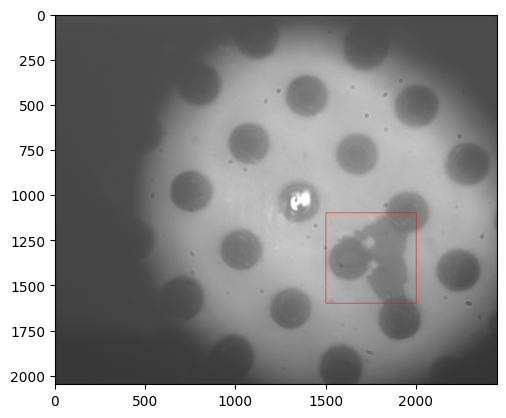

In [972]:
x_start = 1500 
y_start = 1100  
width = 500   
height = 500   
image_ROI = image_current[y_start:y_start+height, x_start:x_start+width]

feature_position = find_feature_position(image_current, image_ROI)

x, y = feature_position
# Draw a rectangle around the feature for visualization
cv2.rectangle(image_current, (x, y), (x + image_ROI.shape[1], y + image_ROI.shape[0]), 255, 2)
plt.imshow(image_current)

In [973]:
calibration_matrix=calibrate_stage(image_ROI)

0.8123142719268799 (1500, 1100)
x moved by 5000
y moved by 0
0.808401346206665 (1535, 1060)
0.8083857297897339 (1536, 1060)
x moved by 0
y moved by 5000
0.8031588196754456 (1498, 1020)
0.8028990626335144 (1498, 1018)
x moved by -5000
y moved by -5000
0.8119392395019531 (1500, 1100)
0.8119182586669922 (1500, 1100)
x moved by -3000
y moved by 0
0.8067817687988281 (1461, 1130)
0.8066096305847168 (1461, 1130)
x moved by 0
y moved by -3000
0.806070864200592 (1485, 1156)
0.8060405254364014 (1486, 1156)
x moved by 3000
y moved by 3000
0.8122777342796326 (1500, 1100)
[[5000, 0], [0, 5000], [-5000, -5000], [-3000, 0], [0, -3000], [3000, 3000]]
[[35, -40], [-38, -40], [2, 82], [-39, 30], [24, 26], [14, -56]]


Initial ROI position is at (1500, 1100)


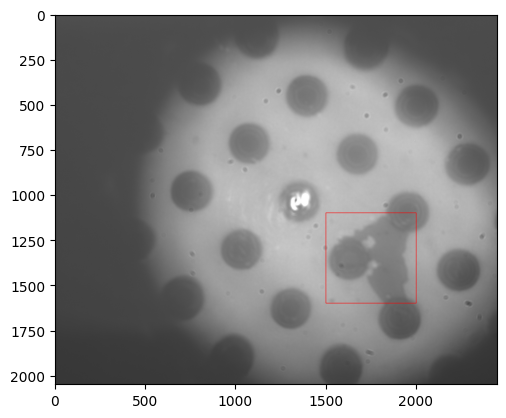

In [974]:
fname='image_initial'
takepic_pointgrey(picture_path+fname)
image = cv2.imread(picture_path+fname+'.png')
initial_ROI_position=find_feature_position(image,image_ROI)
print('Initial ROI position is at',initial_ROI_position)

x, y = initial_ROI_position
# Draw a rectangle around the feature for visualization
cv2.rectangle(image, (x, y), (x + image_ROI.shape[1], y + image_ROI.shape[0]), 255, 2)
plt.imshow(image)

In [977]:
def run_correction(correction_counter):
    time.sleep(10)
    fname='image_drifted_%d'%correction_counter
    takepic_pointgrey(picture_path+fname)
    image = cv2.imread(picture_path+fname+'.png')
    drifted_ROI_position=find_feature_position(image,image_ROI)
    print('Drifted ROI position is at',drifted_ROI_position)

    x, y = drifted_ROI_position

    drift_x,drift_y=drifted_ROI_position[0]-initial_ROI_position[0],\
                  drifted_ROI_position[1]-initial_ROI_position[1]
    
    correct_drift(drift_x,drift_y,calibration_matrix)
    
    fname='image_corrected_%d'%i
    takepic_pointgrey(picture_path+fname)
    
    plt.figure(figsize=(16,4))
    
    plt.subplot(131)
    plt.title('initial')
    fname='image_initial'
    image = cv2.imread(picture_path+fname+'.png')
    plt.imshow(image)
    
    plt.subplot(132)
    plt.title('drifted')
    fname='image_drifted_%d'%i
    image = cv2.imread(picture_path+fname+'.png')
    plt.imshow(image)
    
    plt.subplot(133)
    plt.title('corrected')
    fname='image_corrected_%d'%i
    image = cv2.imread(picture_path+fname+'.png')
    plt.imshow(image)
    correction_counter=correction_counter+1
    return correction_counter

Drifted ROI position is at (1500, 1106)


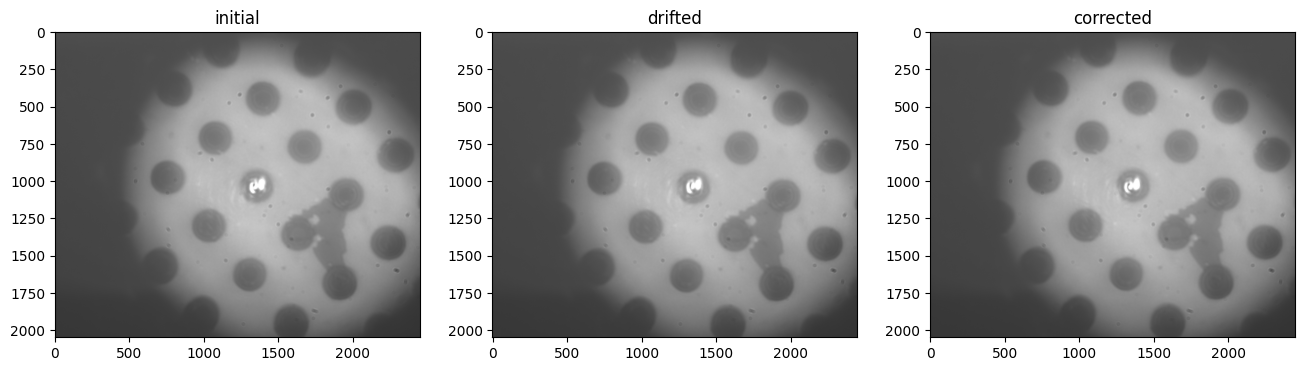

In [978]:
correction_counter=0
run_correction(correction_counter)

x moved by -10895
y moved by 4329
Drifted ROI position is at (1318, 250)


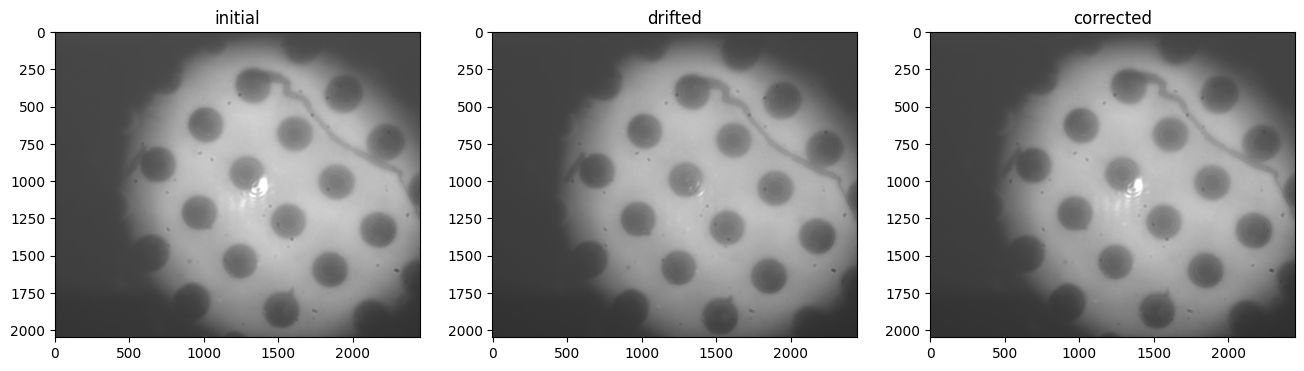

x moved by -3146
y moved by -14159
Drifted ROI position is at (1331, 374)


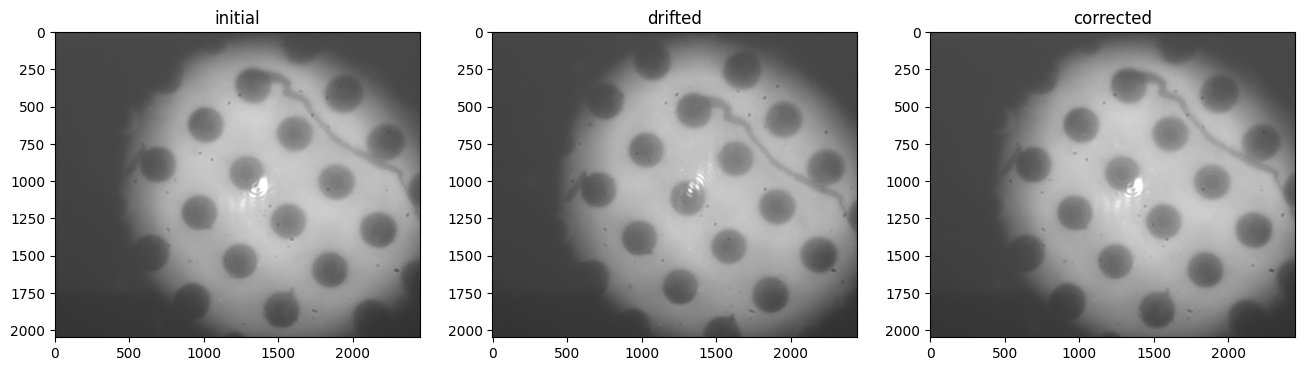

x moved by -14440
y moved by 4180
Drifted ROI position is at (1341, 362)


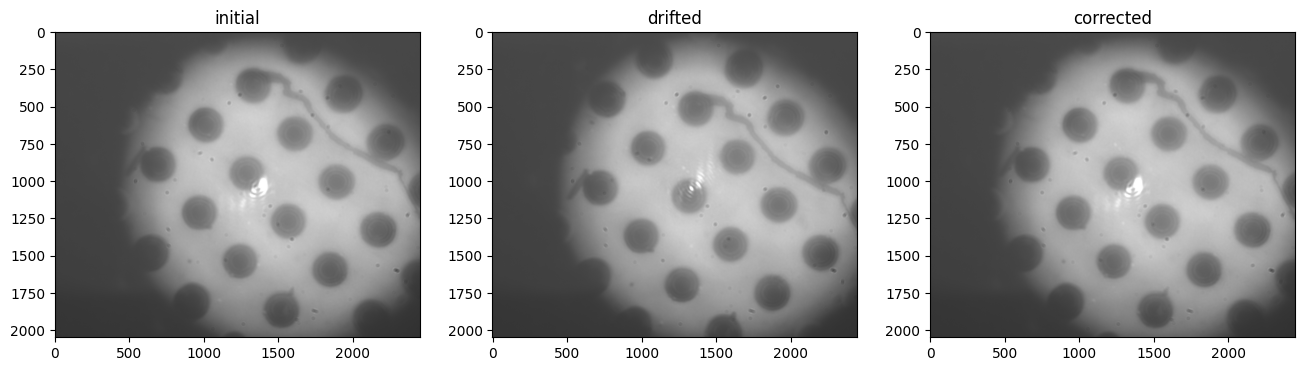

x moved by -6102
y moved by 13880
Drifted ROI position is at (1403, 132)


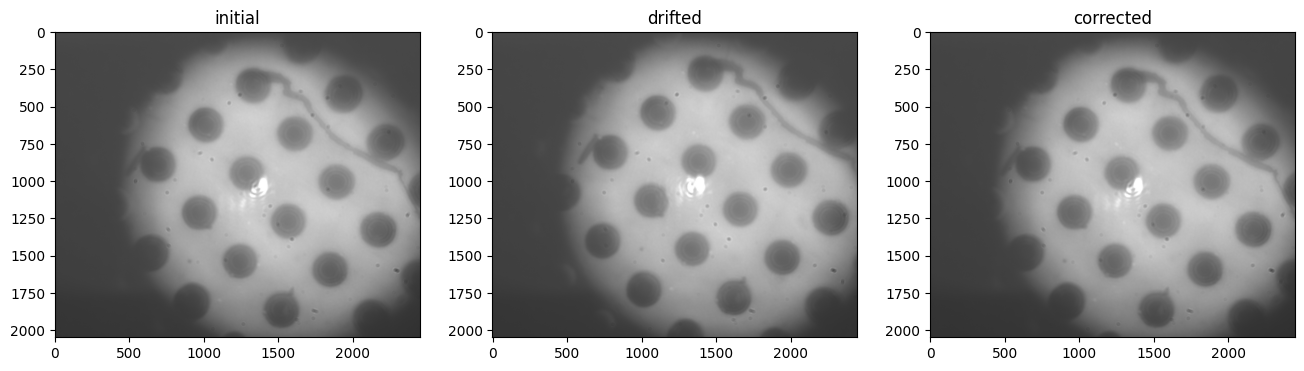

x moved by -13757
y moved by 11496
Drifted ROI position is at (1300, 200)


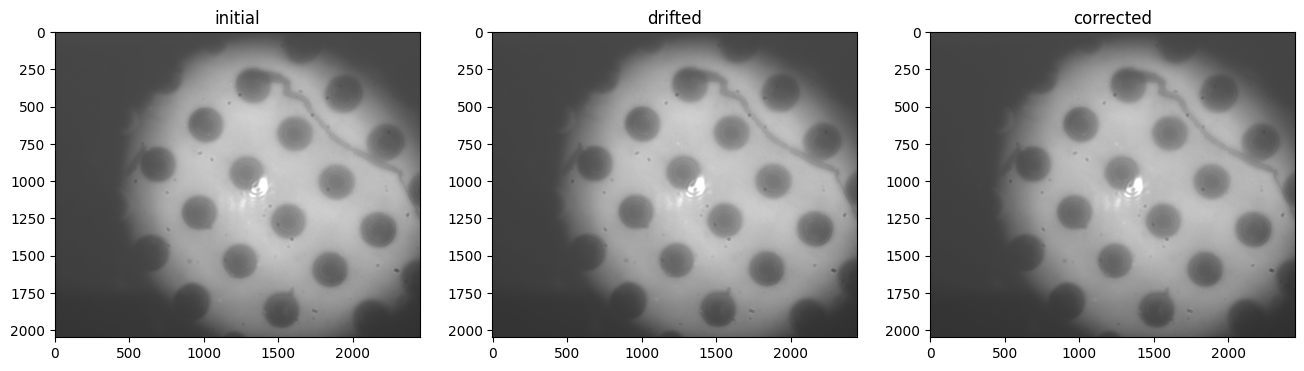

In [830]:
Move=30000
for i in range(5):
    plt.close()
    time.sleep(1)
    stagex.move_by(int((random.random()-0.5)*Move))
    time.sleep(2)
    print(f'x moved by {int((random.random()-0.5)*Move)}')
    stagey.move_by(int((random.random()-0.5)*Move))
    time.sleep(2)
    print(f'y moved by {int((random.random()-0.5)*Move)}')
    
    fname='image_drifted_i'
    takepic_pointgrey(fname)
    image = cv2.imread(fname+'.png')
    drifted_ROI_position=find_feature_position(image,image_ROI)
    print('Drifted ROI position is at',drifted_ROI_position)

    x, y = drifted_ROI_position

    drift_x,drift_y=drifted_ROI_position[0]-initial_ROI_position[0],\
                  drifted_ROI_position[1]-initial_ROI_position[1]
    
    correct_drift(drift_x,drift_y,calibration_matrix)
    
    fname='image_corrected_i'
    takepic_pointgrey(fname)
    
    plt.figure(figsize=(16,4))
    
    plt.subplot(131)
    plt.title('initial')
    fname='image_initial'
    image = cv2.imread(fname+'.png')
    plt.imshow(image)
    
    plt.subplot(132)
    plt.title('drifted')
    fname='image_drifted_i'
    image = cv2.imread(fname+'.png')
    plt.imshow(image)
    
    plt.subplot(133)
    plt.title('corrected')
    fname='image_corrected_i'
    image = cv2.imread(fname+'.png')
    plt.imshow(image)
    
    plt.show()

-729.298014302272